<a href="https://www.kaggle.com/code/starcs2001/playground-series-s4e1-first-draft?scriptVersionId=162497299" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder ,StandardScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [3]:
data_path='/kaggle/input/playground-series-s4e1'
train=pd.read_csv(data_path+'/train.csv')
train_copy=pd.read_csv(data_path+'/train.csv')
test=pd.read_csv(data_path+'/test.csv')
test_copy=pd.read_csv(data_path+'/test.csv')

In [4]:
sample_submission=pd.read_csv(data_path+'/sample_submission.csv')

In [5]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
test.isnull().sum()#no empty values 

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [7]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [8]:
sample_submission

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [9]:
train[train.columns[-1]].unique()#first we identify this is a binary classification problem 

array([0, 1])

In [10]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# EDA

In [11]:
#first we convert categorical features into numerical ones by using pd.get_dummies 

In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [13]:
train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

<Axes: xlabel='Balance', ylabel='Count'>

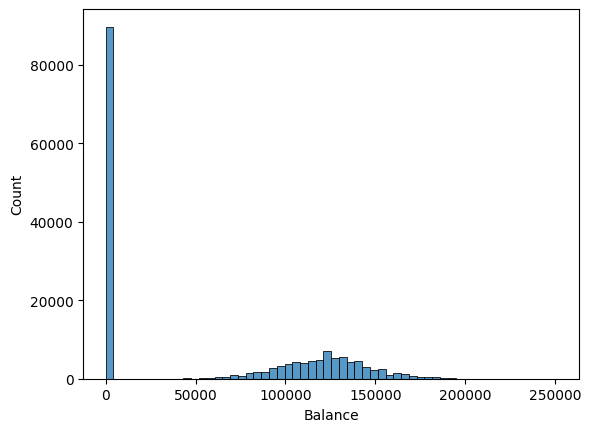

In [14]:
sns.histplot(data=train['Balance'])## here we can see there are outlier present 

In [15]:
#to balance it out we can either use the standardisation techniques or directly drop the data 

In [16]:
len(train[train['Balance']<10])/len(train)

0.5432092780881516

In [17]:
#so we cant drop the data since there are more than 50 percent dat missing 
### the candidates are monte carlo simulation to draw more samples 
### directly standardissation wont work since data is dominated by missing value 

In [18]:
#

# yeo johnson Transform for Outlier dominated data 

In [19]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

In [20]:
import pandas as pd
from scipy.stats import yeojohnson



transformed_data, lambda_value = yeojohnson(train['Balance'])

# Replace the original column with the transformed data
train['Balance'] = transformed_data

print("Transformed DataFrame:")
print(train)
print("Lambda value:", lambda_value)


Transformed DataFrame:
            id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure   Balance  NumOfProducts  HasCr

In [21]:
import pandas as pd
from scipy.stats import yeojohnson



transformed_data, lambda_value = yeojohnson(test['Balance'])

# Replace the original column with the transformed data
test['Balance'] = transformed_data

print("Transformed DataFrame:")
print(test)
print("Lambda value:", lambda_value)

Transformed DataFrame:
            id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
0       165034    15773898   Lucchese          586    France  Female  23.0   
1       165035    15782418       Nott          683    France  Female  46.0   
2       165036    15807120         K?          656    France  Female  34.0   
3       165037    15808905  O'Donnell          681    France    Male  36.0   
4       165038    15607314    Higgins          752   Germany    Male  38.0   
...        ...         ...        ...          ...       ...     ...   ...   
110018  275052    15662091      P'eng          570     Spain    Male  29.0   
110019  275053    15774133        Cox          575    France  Female  36.0   
110020  275054    15728456      Ch'iu          712    France    Male  31.0   
110021  275055    15687541   Yegorova          709    France  Female  32.0   
110022  275056    15663942       Tuan          621    France  Female  37.0   

        Tenure   Balance  NumOfProducts 

# improvement define a function instead for cleaning in further iterations 

In [22]:
train=pd.concat([train,pd.get_dummies(train[['Geography','Gender','HasCrCard','IsActiveMember']])],axis=1)

In [23]:
test=pd.concat([test,pd.get_dummies(test[['Geography','Gender','IsActiveMember','HasCrCard']])],axis=1)

In [24]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,-0.000000,2,...,0.0,181449.97,0,1.0,0.0,True,False,False,False,True
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,-0.000000,2,...,1.0,49503.50,0,1.0,1.0,True,False,False,False,True
2,2,15694510,Hsueh,678,France,Male,40.0,10,-0.000000,2,...,0.0,184866.69,0,1.0,0.0,True,False,False,False,True
3,3,15741417,Kao,581,France,Male,34.0,2,9.224872,1,...,1.0,84560.88,0,1.0,1.0,True,False,False,False,True
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,-0.000000,2,...,1.0,15068.83,0,1.0,1.0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,-0.000000,1,...,1.0,131834.75,0,1.0,1.0,False,False,True,True,False
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,-0.000000,1,...,0.0,131834.45,0,0.0,0.0,True,False,False,False,True
165031,165031,15664752,Hsia,565,France,Male,31.0,5,-0.000000,1,...,1.0,127429.56,0,1.0,1.0,True,False,False,False,True
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,9.272552,1,...,1.0,71173.03,0,0.0,1.0,False,False,True,True,False


In [25]:
test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,IsActiveMember,HasCrCard,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,165034,15773898,Lucchese,586,France,Female,23.0,2,-0.000000,2,0.0,1.0,160976.75,1.0,0.0,True,False,False,True,False
1,165035,15782418,Nott,683,France,Female,46.0,2,-0.000000,1,1.0,0.0,72549.27,0.0,1.0,True,False,False,True,False
2,165036,15807120,K?,656,France,Female,34.0,7,-0.000000,2,1.0,0.0,138882.09,0.0,1.0,True,False,False,True,False
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,-0.000000,1,1.0,0.0,113931.57,0.0,1.0,True,False,False,False,True
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,9.049433,1,1.0,0.0,139431.00,0.0,1.0,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,9.024020,1,1.0,1.0,148087.62,1.0,1.0,False,False,True,False,True
110019,275053,15774133,Cox,575,France,Female,36.0,4,9.271485,1,1.0,1.0,42181.68,1.0,1.0,True,False,False,True,False
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,-0.000000,2,1.0,0.0,16287.38,0.0,1.0,True,False,False,False,True
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,-0.000000,1,1.0,1.0,158816.58,1.0,1.0,True,False,False,True,False


#### irrelevant features 

In [26]:
#data has surname and information of customers columns which is irrelevant 
train=train.drop(columns=['id','CustomerId','Surname','Geography','Gender','HasCrCard','IsActiveMember','Balance'],axis=1)

In [27]:
train

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,2,181449.97,0,True,False,False,False,True
1,627,33.0,1,2,49503.50,0,True,False,False,False,True
2,678,40.0,10,2,184866.69,0,True,False,False,False,True
3,581,34.0,2,1,84560.88,0,True,False,False,False,True
4,716,33.0,5,2,15068.83,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,1,131834.75,0,False,False,True,True,False
165030,792,35.0,3,1,131834.45,0,True,False,False,False,True
165031,565,31.0,5,1,127429.56,0,True,False,False,False,True
165032,554,30.0,7,1,71173.03,0,False,False,True,True,False


In [28]:
#data has surname and information of customers columns which is irrelevant 
test=test.drop(columns=['id','CustomerId','Surname','Geography','Gender','IsActiveMember','HasCrCard','Balance'],axis=1)

In [29]:
test  

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,586,23.0,2,2,160976.75,True,False,False,True,False
1,683,46.0,2,1,72549.27,True,False,False,True,False
2,656,34.0,7,2,138882.09,True,False,False,True,False
3,681,36.0,8,1,113931.57,True,False,False,False,True
4,752,38.0,10,1,139431.00,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
110018,570,29.0,7,1,148087.62,False,False,True,False,True
110019,575,36.0,4,1,42181.68,True,False,False,True,False
110020,712,31.0,2,2,16287.38,True,False,False,False,True
110021,709,32.0,3,1,158816.58,True,False,False,True,False


In [30]:
test['CreditScore']=(test['CreditScore']-test['CreditScore'].mean())/test['CreditScore'].std()
test['Age']=(test['Age']-test['Age'].mean())/test['Age'].std()
test['EstimatedSalary']=(test['EstimatedSalary']-test['EstimatedSalary'].mean())/test['EstimatedSalary'].std()
test['Tenure']=(test['Tenure']-test['Tenure'].mean())/test['Tenure'].std()


In [31]:
train

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,668,33.0,3,2,181449.97,0,True,False,False,False,True
1,627,33.0,1,2,49503.50,0,True,False,False,False,True
2,678,40.0,10,2,184866.69,0,True,False,False,False,True
3,581,34.0,2,1,84560.88,0,True,False,False,False,True
4,716,33.0,5,2,15068.83,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,1,131834.75,0,False,False,True,True,False
165030,792,35.0,3,1,131834.45,0,True,False,False,False,True
165031,565,31.0,5,1,127429.56,0,True,False,False,False,True
165032,554,30.0,7,1,71173.03,0,False,False,True,True,False


In [32]:
train['CreditScore']=(train['CreditScore']-train['CreditScore'].mean())/train['CreditScore'].std()
train['Age']=(train['Age']-train['Age'].mean())/train['Age'].std()
train['EstimatedSalary']=(train['EstimatedSalary']-train['EstimatedSalary'].mean())/train['EstimatedSalary'].std()
train['Tenure']=(train['Tenure']-train['Tenure'].mean())/train['Tenure'].std()

In [33]:
train

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.144134,-0.578073,-0.719971,2,1.369481,0,True,False,False,False,True
1,-0.367705,-0.578073,-1.432689,2,-1.254081,0,True,False,False,False,True
2,0.268973,0.211353,1.774542,2,1.437418,0,True,False,False,False,True
3,-0.941963,-0.465297,-1.076330,1,-0.557016,0,True,False,False,False,True
4,0.743360,-0.578073,-0.007253,2,-1.938764,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
165029,0.131650,-0.578073,-1.076330,1,0.382955,0,False,False,True,True,False
165030,1.692135,-0.352522,-0.719971,1,0.382949,0,True,False,False,False,True
165031,-1.141705,-0.803623,-0.007253,1,0.295365,0,True,False,False,False,True
165032,-1.279027,-0.916398,0.705465,1,-0.823214,0,False,False,True,True,False


#### initial proposed approach will start from logistic then will increase the complexity 

In [34]:
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split

In [35]:
X_train=train.drop('Exited',axis=1)
Y_train=train['Exited']

In [36]:
X_train

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.144134,-0.578073,-0.719971,2,1.369481,True,False,False,False,True
1,-0.367705,-0.578073,-1.432689,2,-1.254081,True,False,False,False,True
2,0.268973,0.211353,1.774542,2,1.437418,True,False,False,False,True
3,-0.941963,-0.465297,-1.076330,1,-0.557016,True,False,False,False,True
4,0.743360,-0.578073,-0.007253,2,-1.938764,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...
165029,0.131650,-0.578073,-1.076330,1,0.382955,False,False,True,True,False
165030,1.692135,-0.352522,-0.719971,1,0.382949,True,False,False,False,True
165031,-1.141705,-0.803623,-0.007253,1,0.295365,True,False,False,False,True
165032,-1.279027,-0.916398,0.705465,1,-0.823214,False,False,True,True,False


In [37]:
clf=LogisticRegression(random_state=0)

In [38]:
clf.fit(X_train,Y_train)

LogisticRegression(random_state=0)

In [39]:
X_Test=test

In [40]:
predictions=clf.predict(test)

In [41]:
clf.predict_proba(X_Test)

array([[0.95278293, 0.04721707],
       [0.57817851, 0.42182149],
       [0.90049185, 0.09950815],
       ...,
       [0.96270673, 0.03729327],
       [0.81336359, 0.18663641],
       [0.75971946, 0.24028054]])

In [42]:
prediction_prob=clf.predict_proba(X_Test)

In [43]:
sample_submission

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [44]:
pd.Series(prediction_prob[:,0],name='Exited')

0         0.952783
1         0.578179
2         0.900492
3         0.869270
4         0.689636
            ...   
110018    0.911655
110019    0.757852
110020    0.962707
110021    0.813364
110022    0.759719
Name: Exited, Length: 110023, dtype: float64

In [45]:
prd_prob_series=pd.Series(prediction_prob[:,1],name='Exited')

In [46]:
prd_prob_df=pd.DataFrame(prd_prob_series)

In [47]:
prd_prob_df

,Exited
0,0.047217
1,0.421821
2,0.099508
3,0.130730
4,0.310364
...,...
110018,0.088345
110019,0.242148
110020,0.037293
110021,0.186636


In [48]:
submission_file=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_df],axis=1),test_copy['id']],axis=1)[['id','Exited']])

In [49]:
submission_file.head()

,id,Exited
0,165034,0.047217
1,165035,0.421821
2,165036,0.099508
3,165037,0.130730
4,165038,0.310364


In [50]:
submission_file.to_csv('/kaggle/working/submission_logistic.csv',index=False)

In [51]:
test

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.878173,-1.706497,-1.067883,2,0.967869,True,False,False,True,False
1,0.329566,0.888986,-1.067883,1,-0.790935,True,False,False,True,False
2,-0.006609,-0.465179,0.713919,2,0.528411,True,False,False,True,False
3,0.304664,-0.239485,1.070279,1,0.032150,True,False,False,False,True
4,1.188679,-0.013790,1.783000,1,0.539329,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
110018,-1.077387,-1.029414,0.713919,1,0.711507,False,False,True,False,True
110019,-1.015133,-0.239485,-0.355162,1,-1.394940,True,False,False,True,False
110020,0.690642,-0.803720,-1.067883,2,-1.909972,True,False,False,False,True
110021,0.653289,-0.690873,-0.711522,1,0.924904,True,False,False,True,False


### Now that we have our baseline model eshtablished Lets work on Tree based and Ensemble approaches 

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [53]:
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [54]:
# dtree_grid_search(X_train,Y_train,4)

In [55]:
classifier_tree = DecisionTreeClassifier(max_depth=6)

In [56]:
classifier_tree.fit(X_train,Y_train, )

DecisionTreeClassifier(max_depth=6)

In [57]:
classifier_tree.predict(X_Test)

array([0, 1, 0, ..., 0, 0, 0])

In [58]:
clf.predict_proba(X_Test)

array([[0.95278293, 0.04721707],
       [0.57817851, 0.42182149],
       [0.90049185, 0.09950815],
       ...,
       [0.96270673, 0.03729327],
       [0.81336359, 0.18663641],
       [0.75971946, 0.24028054]])

In [59]:
tree_prob=classifier_tree.predict_proba(X_Test)

In [60]:
prd_prob_series_tree=pd.Series(tree_prob[:,1],name='Exited')

In [61]:
submission_file_tree=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_series_tree],axis=1),test_copy['id']],axis=1)[['id','Exited']])

In [62]:
submission_file_tree

,id,Exited
0,165034,0.032245
1,165035,0.707590
2,165036,0.032245
3,165037,0.139757
4,165038,0.258199
...,...,...
110018,275052,0.096082
110019,275053,0.239798
110020,275054,0.016888
110021,275055,0.167940


In [63]:
submission_file_tree.to_csv('/kaggle/working/submission_tree.csv',index=False)

#### for XGboost or any boosting algo we need a validation train and test data set 


In [64]:
X_Test

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.878173,-1.706497,-1.067883,2,0.967869,True,False,False,True,False
1,0.329566,0.888986,-1.067883,1,-0.790935,True,False,False,True,False
2,-0.006609,-0.465179,0.713919,2,0.528411,True,False,False,True,False
3,0.304664,-0.239485,1.070279,1,0.032150,True,False,False,False,True
4,1.188679,-0.013790,1.783000,1,0.539329,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
110018,-1.077387,-1.029414,0.713919,1,0.711507,False,False,True,False,True
110019,-1.015133,-0.239485,-0.355162,1,-1.394940,True,False,False,True,False
110020,0.690642,-0.803720,-1.067883,2,-1.909972,True,False,False,False,True
110021,0.653289,-0.690873,-0.711522,1,0.924904,True,False,False,True,False


## Now we will go for XGboost

In [65]:
from xgboost import XGBClassifier

Xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')



In [66]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


In [67]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(Xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,Y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, Y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7bfb69530dd0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None, n_estimators=2,
                                           n_jobs=None, num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [68]:
xgb_prob=random_search.predict_proba(X_Test)

In [69]:
prd_prob_series_xgb=pd.Series(xgb_prob[:,1],name='Exited')

In [70]:
submission_file_xgb=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_series_xgb],axis=1),test_copy['id']],axis=1)[['id','Exited']])

In [71]:
submission_file_xgb.to_csv('/kaggle/working/submission_xgb.csv',index=False)

In [72]:
Y_train

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [73]:
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are your training data and labels
x_train, x_val, y_Train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Now X_train and y_train represent the training set, and X_val and y_val represent the validation set


# Random Forest Approach

In [74]:
#since i dont have any idea about the parameter space i am going for random search method this might be time consuming 

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def random_search_cv_and_train(X_train, y_train, X_val, y_val, n_iter_search=10, cv=5):
    # Define the parameter grid to search
    param_dist = {
        'n_estimators': randint(10, 200),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth': randint(1, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20),
        'bootstrap': [True, False]
    }

    # Create a RandomForestClassifier
    rf = RandomForestClassifier()

    # Create RandomizedSearchCV Object
    random_search = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=n_iter_search, cv=cv, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Fit the model on the training data
    random_search.fit(X_train, y_train)

    # Print the best parameters and corresponding accuracy on validation set
    print("Best Parameters: ", random_search.best_params_)
    print("Best Accuracy on Validation Set: {:.2f}%".format(random_search.best_score_ * 100))

    # Train the final model on the entire training set using the best parameters
    best_model = RandomForestClassifier(**random_search.best_params_)
    best_model.fit(X_train, y_train)

    # Evaluate the final model on the validation set
    y_pred_val = best_model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    print("Final Model Accuracy on Validation Set: {:.2f}%".format(accuracy_val * 100))

    return best_model


In [76]:
# final_model = random_search_cv_and_train(x_train, y_Train, x_val, y_val)




In [77]:
# Best Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 199}
# Best Accuracy on Validation Set: 84.90%

In [78]:
# rf_prob=final_model.predict_proba(X_Test)
# prd_prob_series_rf=pd.Series(rf_prob[:,1],name='Exited')
# submission_file_rf=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_series_rf],axis=1),test_copy['id']],axis=1)[['id','Exited']])
# submission_file_rf.to_csv('/kaggle/working/submission_rf.csv',index=False)

In [79]:
# model_XGB_man = XGBClassifier(objective='binary:logistic',
#                       tree_method= 'hist',
#                       subsample= 0.9,
#                       reg_lambda= 2,
#                       reg_alpha= 1,
#                       n_estimators= 200,
#                       min_child_weight= 10,
#                       max_depth= 4,
#                       learning_rate= 0.1,
#                       gamma= 1,
#                       colsample_bytree= 1.0)
# model_XGB_man.fit(X_train,Y_train)


In [80]:
# xgb_prob_man=model_XGB_man.predict_proba(X_Test)

In [81]:
# prd_prob_series_xgb=pd.Series(tree_prob[:,1],name='Exited')

# Xgboost with random Search 


In [82]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from scipy.stats import randint

def random_search_cv_and_train_xgboost(X_train, y_train, X_val, y_val, n_iter_search=10, cv=5):
    # Define the parameter grid to search
    param_dist = {
        'n_estimators': randint(10, 200),
        'max_depth': randint(1, 20),
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 1, 2, 3, 4]
    }

    # Create an XGBClassifier
    xgb = XGBClassifier()

    # Create RandomizedSearchCV Object
    random_search = RandomizedSearchCV(
        xgb, param_distributions=param_dist,
        n_iter=n_iter_search, cv=cv, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Fit the model on the training data
    random_search.fit(X_train, y_train)

    # Print the best parameters and corresponding accuracy on validation set
    print("Best Parameters: ", random_search.best_params_)
    print("Best Accuracy on Validation Set: {:.2f}%".format(random_search.best_score_ * 100))

    # Train the final model on the entire training set using the best parameters
    best_model = XGBClassifier(**random_search.best_params_)
    best_model.fit(X_train, y_train)

    # Evaluate the final model on the validation set
    y_pred_val = best_model.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    print("Final Model Accuracy on Validation Set: {:.2f}%".format(accuracy_val * 100))

    return best_model


In [83]:
final_model_Xgb = random_search_cv_and_train_xgboost(x_train, y_Train, x_val, y_val)


Best Parameters:  {'colsample_bytree': 0.9, 'gamma': 2, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 97, 'subsample': 0.9}
Best Accuracy on Validation Set: 85.01%
Final Model Accuracy on Validation Set: 85.22%


In [84]:
xgb_prob_rs=final_model_Xgb.predict_proba(X_Test)
prd_prob_series_xgb_rs=pd.Series(xgb_prob_rs[:,1],name='Exited')
submission_file_xgb_rs=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_series_xgb_rs],axis=1),test_copy['id']],axis=1)[['id','Exited']])
submission_file_xgb_rs.to_csv('/kaggle/working/submission_xgb_rs.csv',index=False)

# Now will work with stacking models assuming baseline as Logistic model 

In [85]:
y=train['Exited']
X=train.drop(columns='Exited')

In [86]:
# stacked_model.predict_proba

# Now lets try with more stacked methods using pipeline of scikit 


In [87]:
X

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.144134,-0.578073,-0.719971,2,1.369481,True,False,False,False,True
1,-0.367705,-0.578073,-1.432689,2,-1.254081,True,False,False,False,True
2,0.268973,0.211353,1.774542,2,1.437418,True,False,False,False,True
3,-0.941963,-0.465297,-1.076330,1,-0.557016,True,False,False,False,True
4,0.743360,-0.578073,-0.007253,2,-1.938764,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...
165029,0.131650,-0.578073,-1.076330,1,0.382955,False,False,True,True,False
165030,1.692135,-0.352522,-0.719971,1,0.382949,True,False,False,False,True
165031,-1.141705,-0.803623,-0.007253,1,0.295365,True,False,False,False,True
165032,-1.279027,-0.916398,0.705465,1,-0.823214,False,False,True,True,False


In [88]:
X=train.drop(columns=['Exited'])

In [89]:
# X.drop(columns=['Surname','CustomerId','id'],inplace=True)

In [90]:
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# class Stacked_model:
#     def __init__(self, lgb_params=None, xgb_params=None):
#         self.lgb_model = lgb.LGBMClassifier(**lgb_params) if lgb_params else None
#         self.xgb_model = xgb.XGBClassifier(**xgb_params) if xgb_params else None

#     def create_train_test_data(self, X, y, test_size=0.2, random_state=42):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#         self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

#     def train(self):
#         if self.lgb_model:
#             self.lgb_model.fit(self.X_train, self.y_train, eval_set=[(self.X_test, self.y_test)], early_stopping_rounds=100, verbose=False)

#         if self.xgb_model:
#             self.xgb_model.fit(self.X_train, self.y_train, eval_set=[(self.X_test, self.y_test)], early_stopping_rounds=10, verbose=False)

#     def predict(self, X):
#         lgb_preds = self.lgb_model.predict(X) if self.lgb_model else None
#         xgb_preds = self.xgb_model.predict(X) if self.xgb_model else None

#         # Implement your stacking logic here, e.g., averaging predictions
#         # For simplicity, this example uses a simple average of predictions.
#         stacked_preds = (lgb_preds + xgb_preds) / 2 if (lgb_preds is not None and xgb_preds is not None) else (lgb_preds or xgb_preds)

#         return stacked_preds

# # Example usage:
# lgb_params = {'n_estimators': 100, 'learning_rate': 0.05}
# xgb_params = {'objective': 'binary:logistic',
#               'tree_method': 'hist',
#               'subsample': 0.9,
#               'reg_lambda': 2,
#               'reg_alpha': 1,
#               'n_estimators': 200,
#               'min_child_weight': 10,
#               'max_depth': 4,
#               'learning_rate': 0.1,
#               'gamma': 1,
#               'colsample_bytree': 1.0}

# stacked_model = Stacked_model(lgb_params=lgb_params, xgb_params=xgb_params)

# # Assuming you have your features (X) and labels (y)
# stacked_model.create_train_test_data(X, y)

# # Train the model
# stacked_model.train()

# # Make predictions
# predictions = stacked_model.predict(test)


### identifying the categorical and numerical features

In [91]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

[]

In [92]:
num_selector(X)

['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'EstimatedSalary']

In [93]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor


ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bfb694fe5c0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bfb69519ff0>)])

In [94]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bfb694fe5c0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7bfb69519ff0>)])

In [95]:
from sklearn.ensemble import RandomForestClassifier


rf_pipeline = make_pipeline(tree_preprocessor, 
                            RandomForestClassifier(random_state=42,
                                                   bootstrap=True,
                                                   max_depth=10,
                                                   max_features=None,
                                                   min_samples_leaf=16,
                                                   min_samples_split=16,
                                                   n_estimators=199))




In [96]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

# Assuming you have defined tree_preprocessor somewhere in your code
# Assuming you have X and y datasets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestClassifier pipeline
rf_pipeline = make_pipeline(tree_preprocessor, 
                            RandomForestClassifier(random_state=42,
                                                   bootstrap=True,
                                                   max_depth=10,
                                                   max_features=None,
                                                   min_samples_leaf=16,
                                                   min_samples_split=16,
                                                   n_estimators=199))

# XGBoostClassifier pipeline with your specified parameters
xgb_pipeline = make_pipeline(tree_preprocessor,
                             XGBClassifier(objective='binary:logistic',
                                           tree_method='hist',
                                           subsample=0.9,
                                           reg_lambda=2,
                                           reg_alpha=1,
                                           n_estimators=200,
                                           min_child_weight=10,
                                           max_depth=4,
                                           learning_rate=0.1,
                                           gamma=1,
                                           colsample_bytree=1.0,
                                           random_state=42))


# Combine the three models using VotingClassifier
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_pipeline),
    ('xgb', xgb_pipeline),
], voting='soft')  # You can use 'hard' for majority voting or 'soft' for weighted voting

# Train the ensemble on the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions_proba = voting_classifier.predict_proba(X_test)

# Display the predicted probabilities
print(predictions_proba)


[[0.87608994 0.12391006]
 [0.96585252 0.03414747]
 [0.15646039 0.84353961]
 ...
 [0.82009713 0.17990288]
 [0.97569267 0.02430734]
 [0.88809268 0.11190733]]


In [97]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import FunctionTransformer
# from xgboost import XGBClassifier
# from sklearn.metrics import mean_absolute_error
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Function to convert DataFrame to numpy array (if needed)
# def convert_to_array(X):
#     return X.values if isinstance(X, pd.DataFrame) else X

# # Assuming you have defined tree_preprocessor somewhere in your code
# # Assuming you have X and y datasets

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # RandomForestClassifier pipeline
# rf_pipeline = make_pipeline(tree_preprocessor, 
#                             RandomForestClassifier(random_state=42,
#                                                    bootstrap=True,
#                                                    max_depth=10,
#                                                    max_features=None,
#                                                    min_samples_leaf=16,
#                                                    min_samples_split=16,
#                                                    n_estimators=199))

# # XGBoostClassifier pipeline with your specified parameters
# xgb_pipeline = make_pipeline(tree_preprocessor,
#                              XGBClassifier(objective='binary:logistic',
#                                            tree_method='hist',
#                                            subsample=0.9,
#                                            reg_lambda=2,
#                                            reg_alpha=1,
#                                            n_estimators=200,
#                                            min_child_weight=10,
#                                            max_depth=4,
#                                            learning_rate=0.1,
#                                            gamma=1,
#                                            colsample_bytree=1.0,
#                                            random_state=42))

# # Logistic Regression pipeline
# logreg_pipeline = make_pipeline(tree_preprocessor,
#                                 LogisticRegression(random_state=42))

# # Neural Network pipeline
# nn_pipeline = make_pipeline(FunctionTransformer(convert_to_array, validate=False),
#                              MLPClassifier(hidden_layer_sizes=(100, ), max_iter=1000, random_state=42))

# # Combine the models using VotingClassifier
# voting_classifier = VotingClassifier(estimators=[
#     ('rf', rf_pipeline),
#     ('xgb', xgb_pipeline),
#     ('logreg', logreg_pipeline),
#     ('nn', nn_pipeline)
# ], voting='soft')  # You can use 'hard' for majority voting or 'soft' for weighted voting

# # Train the ensemble on the training data
# voting_classifier.fit(X_train, y_train)

# # Make predictions on the test data
# predictions_proba = voting_classifier.predict_proba(X_test)

# # Assuming predictions_proba contains the probability estimates for the positive class
# # For binary classification, you typically use probabilities for the positive class (class 1)
# predictions = predictions_proba[:, 1]

# # Calculate the Mean Absolute Error (MAE)
# mae = mean_absolute_error(y_test, predictions)

# # Display the MAE
# print(f'Mean Absolute Error: {mae}')


In [98]:
# voting_classifier

In [99]:
from sklearn.metrics import mean_absolute_error

predictions = predictions_proba[:, 1]

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Display the MAE
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.227034541832454


In [100]:
X_Test=test

In [101]:
X_test

,CreditScore,Age,Tenure,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
33042,1.767038,-0.803623,1.061824,1,-0.656104,True,False,False,True,False
36330,-0.342737,-1.367498,0.349106,2,-1.479018,True,False,False,False,True
59446,-1.141705,0.098578,0.705465,3,-0.865375,True,False,False,False,True
92278,-0.043124,1.902980,-1.076330,1,-0.998693,False,False,True,False,True
146750,-1.241576,-0.803623,0.349106,1,-0.422904,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
32661,0.780812,-1.254723,-1.076330,2,-0.751077,True,False,False,True,False
117592,1.454941,-0.690848,-0.363612,1,-0.369669,True,False,False,True,False
2194,1.380038,-0.352522,0.705465,1,0.059487,False,True,False,True,False
141678,-0.043124,-0.578073,1.418183,2,0.236913,True,False,False,True,False


In [102]:
predictions_proba_final = voting_classifier.predict_proba(X_Test)


In [103]:
predictions_proba_final

array([[0.95872507, 0.04127494],
       [0.39772836, 0.60227164],
       [0.98013557, 0.01986442],
       ...,
       [0.96938062, 0.03061938],
       [0.86578429, 0.13421571],
       [0.74130766, 0.25869232]])

In [104]:

prd_prob_series_voting=pd.Series(predictions_proba_final[:,1],name='Exited')
submission_file_voting=pd.DataFrame(pd.concat([pd.concat([test,prd_prob_series_voting],axis=1),test_copy['id']],axis=1)[['id','Exited']])
submission_file_voting.to_csv('/kaggle/working/submission_voting.csv',index=False)